In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from arena import plot_trajectory

In [6]:
df_enters = pd.read_csv("data/stats/enters_2cm_walking.csv")
df_exits = pd.read_csv("data/stats/exits_2cm_walking.csv")

In [12]:
df_enters.columns

Index(['fly', 'level_1', 'cum_dist', 't', 'timestamp', 'frame', 'x_px', 'y_px',
       'led_1', 'fname', 'segment', 'tseg', 'segment_start_ts', 'transx',
       'transy', 'estimated_food_x', 'estimated_food_y', 'condition',
       'cum_dist_seg', 'cum_dist_fly', 'fr_x_px', 'fr_y_px', 'distance_reward',
       'dist_fictive_reward', 'fr_x_cm', 'fr_y_cm', 'distance_reward_cm',
       'dist_fictive_reward_cm', 'transx_cm', 'transy_cm', 'x_cm', 'y_cm',
       'estimated_food_x_cm', 'estimated_food_y_cm', 'cum_dist_cm',
       'cum_dist_seg_cm', 'cum_dist_fly_cm'],
      dtype='object')

Trajectories: 2 cm neighbourhood of displacement start and displacement end.

In [8]:
from scipy.spatial import distance

In [13]:
def mark_close_exit(flyexit, flyid, threshold):
#     flyid = flyenter.iloc[0].fly
    flyenter = df_enters[df_enters.fly == flyid]
    
    # the block below is to make last point of enter trajectory same to first point of exit trajectory.
    last_enter_x = flyenter.iloc[-1].x_cm
    last_enter_y = flyenter.iloc[-1].y_cm
    first_exit_x = flyexit.iloc[0].x_cm
    first_exit_y = flyexit.iloc[0].y_cm
    dx = first_exit_x - last_enter_x
    dy = first_exit_y - last_enter_y
    flyexit["rel_x"] = flyexit.x_cm - dx
    flyexit["rel_y"] = flyexit.y_cm - dy
    
    exitcoords = flyexit[["rel_x", "rel_y"]].values
    entercoords = flyenter[["x_cm", "y_cm"]].values

    cdists = distance.cdist(exitcoords, entercoords)
    close = cdists<threshold
    exits_close = close.sum(axis=1)
    flyexit["is_close"] = (exits_close>0)
    return flyexit

In [14]:
import numpy as np

In [15]:
def get_length(data, iid):
    x0=data.iloc[0].rel_x
    x1=data.iloc[-1].rel_x
    y0=data.iloc[0].rel_y
    y1=data.iloc[-1].rel_y
    l = np.sqrt((x1-x0)**2+(y1-y0)**2)
#     return pd.Series({"iid":iid, "length":l})
    return l

In [16]:
import seaborn as sns

In [17]:
marked_exits = df_exits.groupby("fly").apply(lambda d: mark_close_exit(d, d.name, threshold=0.25))

In [18]:
marked_exits["iid"] = marked_exits.groupby('fly').is_close.transform(lambda col: col.diff().fillna(0).cumsum())

In [19]:
intersections = marked_exits[marked_exits.is_close].groupby(["fly","iid"]).apply(lambda g:get_length(g,g.name[1]))

max_intersections = intersections.groupby("fly").max()

/home/anna/miniconda3/envs/flyvenv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='condition', ylabel='intersection'>

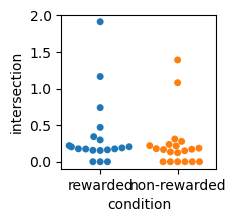

In [20]:
condi=df_exits.groupby('fly')['condition'].first()

intersectdf = pd.DataFrame(max_intersections, columns=["intersection"]).join(condi)

intersectdf = intersectdf.reset_index()

f, ax = plt.subplots(figsize=[2,2])
sns.swarmplot(x='condition', y='intersection',data=intersectdf)

In [21]:
tops = intersectdf[intersectdf.intersection > 0.5].sort_values(by="intersection", ascending=False)

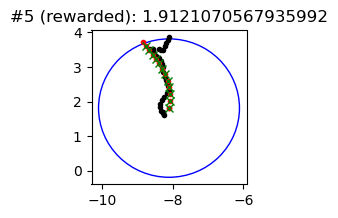

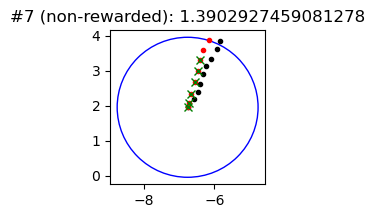

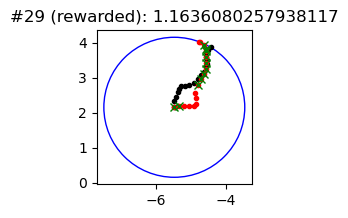

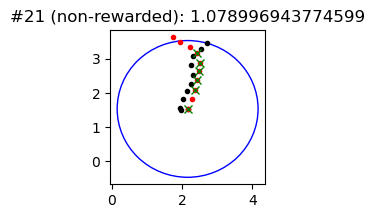

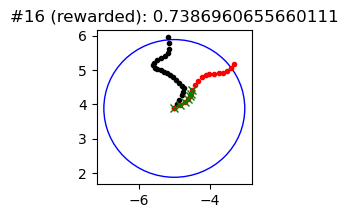

In [22]:
# for fly, data in marked_enters.groupby("fly"):
for fly in tops.fly:
    flyexit = marked_exits[marked_exits.fly==fly]
    flyenter = df_enters[df_enters.fly==fly]
    
    f, ax= plt.subplots(figsize=(2,2))
    ax.plot(flyenter.x_cm, flyenter.y_cm,'.', color="black")
    
    ax.plot(flyexit.rel_x,flyexit.rel_y,'.', color="red")
    ax.plot(flyexit[flyexit.is_close].rel_x,flyexit[flyexit.is_close].rel_y,'x', color="green")

    circle = plt.Circle((flyenter.iloc[-1].x_cm, flyenter.iloc[-1].y_cm), 2, color='b', fill=False)
    ax.add_patch(circle)
    intersection_score = intersectdf.set_index("fly").loc[fly,'intersection']
    condition = flyexit.iloc[0].condition
    ax.set_title(f"#{fly} ({condition}): {intersection_score}")    

In [23]:
rew = intersectdf[intersectdf.condition=='rewarded'].intersection
nonrew = intersectdf[intersectdf.condition!='rewarded'].intersection
from scipy.stats import mannwhitneyu
mannwhitneyu(rew, nonrew)

MannwhitneyuResult(statistic=233.0, pvalue=0.22957066220443778)

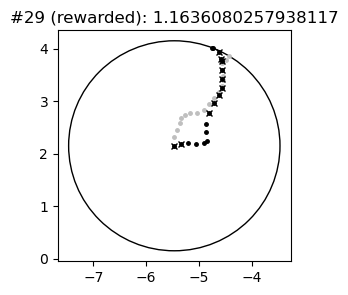

In [24]:
for fly in [29]:
    flyexit = marked_exits[marked_exits.fly==fly]
    flyenter = df_enters[df_enters.fly==fly]
    
    f, ax= plt.subplots(figsize=(3,3))
    ax.plot(flyenter.x_cm, flyenter.y_cm,'.', color="0.75", ms=5)
    
    ax.plot(flyexit.rel_x,flyexit.rel_y,'.', color="black", ms=5)
    ax.plot(flyexit[flyexit.is_close].rel_x,flyexit[flyexit.is_close].rel_y,'x', ms=5,color="k")

    circle = plt.Circle((flyenter.iloc[-1].x_cm, flyenter.iloc[-1].y_cm), 2, color='k', fill=False)
    ax.add_patch(circle)
    intersection_score = intersectdf.set_index("fly").loc[fly,'intersection']
    condition = flyexit.iloc[0].condition
    ax.set_title(f"#{fly} ({condition}): {intersection_score}")    
    plt.savefig("intersection_score.svg")